##### Copyright 2018 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Install, Import, Load Model

In [0]:
# Imports

import numpy as np
import tensorflow as tf

from lucid.modelzoo import vision_models
from lucid.misc.io import show, load, save
from lucid.misc.tfutil import create_session

import lucid.optvis.objectives as objectives
import lucid.optvis.param as param
import lucid.optvis.render as render
from lucid.optvis.objectives import wrap_objective
import lucid.optvis.transform as transform

And we'll use our default vision model, GoogLeNet:

In [0]:
model = vision_models.InceptionV1()
model.load_graphdef()

You can use this to see if you're running on a machine with a correctly configured GPU:

In [29]:
tf.test.is_gpu_available()

True

## Load input images

First, let's take a look at the two images we want to transfer styles between. This code should feel familiar from the Lucid tutorial:

Later in the notebook there'll be an opportunity to upload your own images, too.

(512, 512, 3) (512, 700, 3)



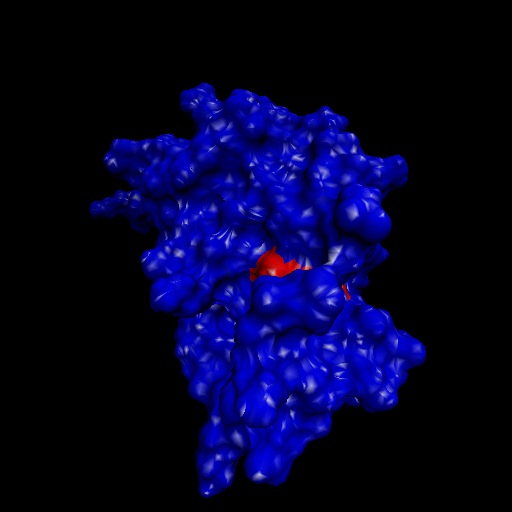


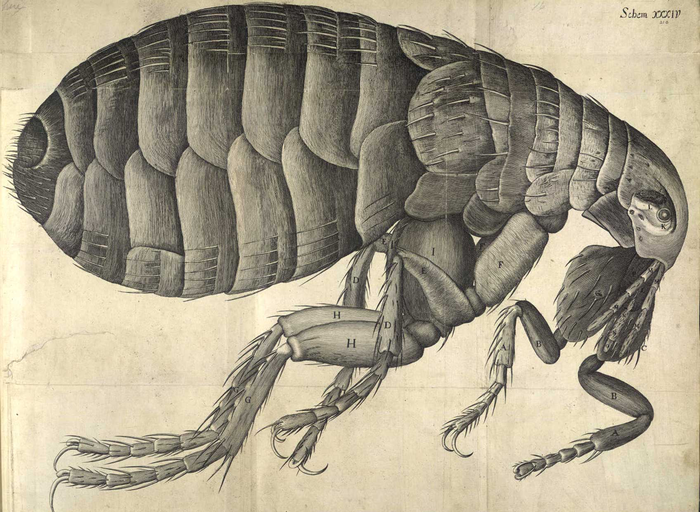

In [30]:
def load_img(path_to_img, max_dim=512):
  from PIL import Image
  img = Image.open(path_to_img)
  long = min(img.size)
  scale = max_dim/long
  img = np.asarray(img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), 
                   Image.ANTIALIAS))
  img_max = np.iinfo(img.dtype).max
  npimg = np.divide(img, img_max, dtype=np.float32)
  return npimg
from os.path import basename
content_path = "bgcol16_EdgyShiny_Surf_Chain.tga"
content_name = basename(content_path).split('.')[0]
style_path = "hooke.jpg"
style_name = basename(style_path).split('.')[0]
content_image = load_img(content_path)


style_image = load_img(style_path) 
print(content_image.shape, style_image.shape)

show(content_image)
show(style_image, domain=None)

In [0]:
def style_transfer_param(content_image, style_image, decorrelate=True, fft=True):
  style_transfer_input = param.image(*content_image.shape[:2], decorrelate=decorrelate, fft=fft)[0]
  content_input = content_image
  style_input = tf.random_crop(style_image, content_image.shape)
  return tf.stack([style_transfer_input, content_input, style_input])

# these constants help remember which image is at which batch dimension
TRANSFER_INDEX = 0
CONTENT_INDEX = 1
STYLE_INDEX = 2

def mean_L1(a, b):
  return tf.reduce_mean(tf.abs(a-b))


@wrap_objective
def activation_difference(layer_names, activation_loss_f=mean_L1, transform_f=None, difference_to=CONTENT_INDEX):
  def inner(T):
    # first we collect the (constant) activations of image we're computing the difference to
    image_activations = [T(layer_name)[difference_to] for layer_name in layer_names]
    if transform_f is not None:
      image_activations = [transform_f(act) for act in image_activations]
    
    # we also set get the activations of the optimized image which will change during optimization
    optimization_activations = [T(layer)[TRANSFER_INDEX] for layer in layer_names]
    if transform_f is not None:
      optimization_activations = [transform_f(act) for act in optimization_activations]
    
    # we use the supplied loss function to compute the actual losses
    losses = [activation_loss_f(a, b) for a, b in zip(image_activations, optimization_activations)]
    return tf.add_n(losses) 
    
  return inner


def gram_matrix(array, normalize_magnitue=True):
  channels = tf.shape(array)[-1]
  array_flat = tf.reshape(array, [-1, channels])
  gram_matrix = tf.matmul(array_flat, array_flat, transpose_a=True)
  if normalize_magnitue:
    length = tf.shape(array_flat)[0]
    gram_matrix /= tf.cast(length, tf.float32)
  return gram_matrix

Now we have all the ingredients to set up an optimization in lucid: we will create two `activation_difference` objectives, a normal one for the **content loss**, and one transforming the activations using `gram_matrix` for the **style loss**.

## Style transfer with extra transforms

In [43]:
# The layers
style_layers = [
  'mixed3b'
]

content_layers = [
  'mixed3b'
]

# Objectives (including decorrelation)
style_weight = 5
content_weight=100
param_f = lambda: style_transfer_param(content_image, style_image)

content_obj = content_weight * activation_difference(content_layers, 
                                                     difference_to=CONTENT_INDEX)
content_obj.description = "Content Loss"

style_obj = style_weight*activation_difference(style_layers, 
                                               transform_f=gram_matrix, 
                                               difference_to=STYLE_INDEX)
style_obj.description = "Style Loss"

objective = - content_obj - style_obj

# transforms
JITTER = 1
ROTATE = 5
SCALE  = 1.1

transforms = [
    transform.pad(2*JITTER),
    transform.jitter(JITTER),
    transform.random_scale([SCALE ** (n/10.) for n in range(-10, 11)]),
    transform.random_rotate(range(-ROTATE, ROTATE+1))
]

vis = render.render_vis(model, objective, transforms=transforms, 
                        param_f=param_f, thresholds=[10,100,500,1000], 
                        verbose=True)



Output hidden; open in https://colab.research.google.com to view.


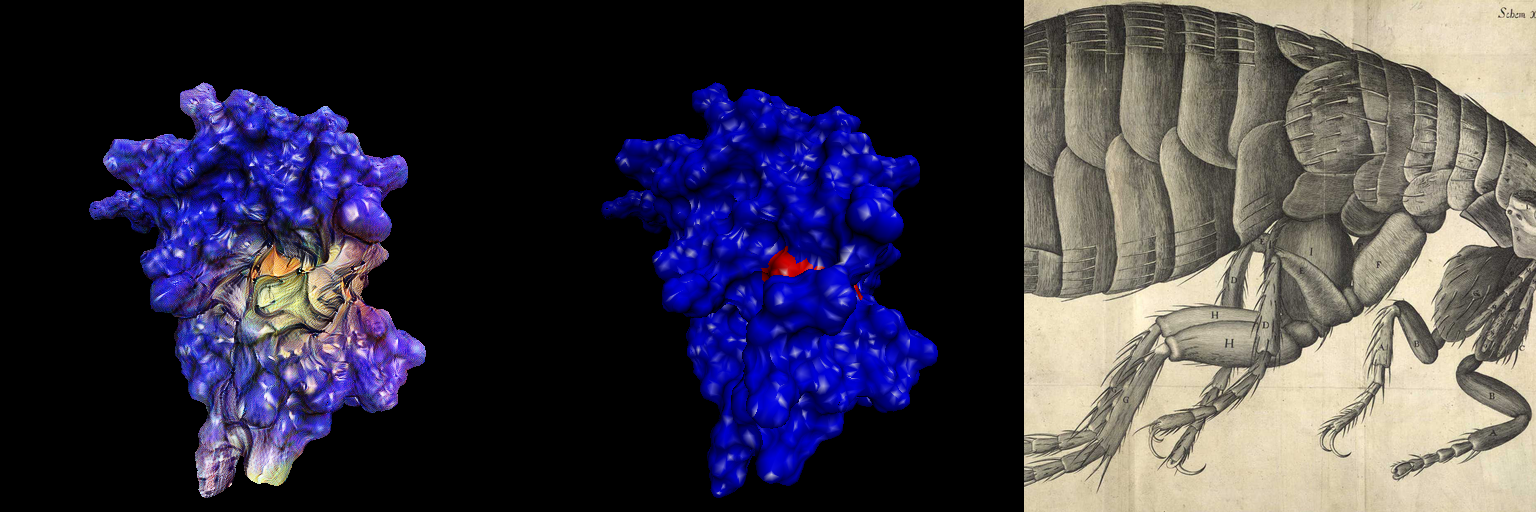

In [45]:
fname = '{0}_{1}_{2}_{3}_{4}_{5}_{6}-transform.jpg'.format(content_name, style_name, model.name, 
                                            content_weight, '-'.join(content_layers), style_weight, '-'.join(style_layers))
show(np.concatenate(vis[-1], axis=1))

save(np.concatenate(vis[-1], axis=1), fname)


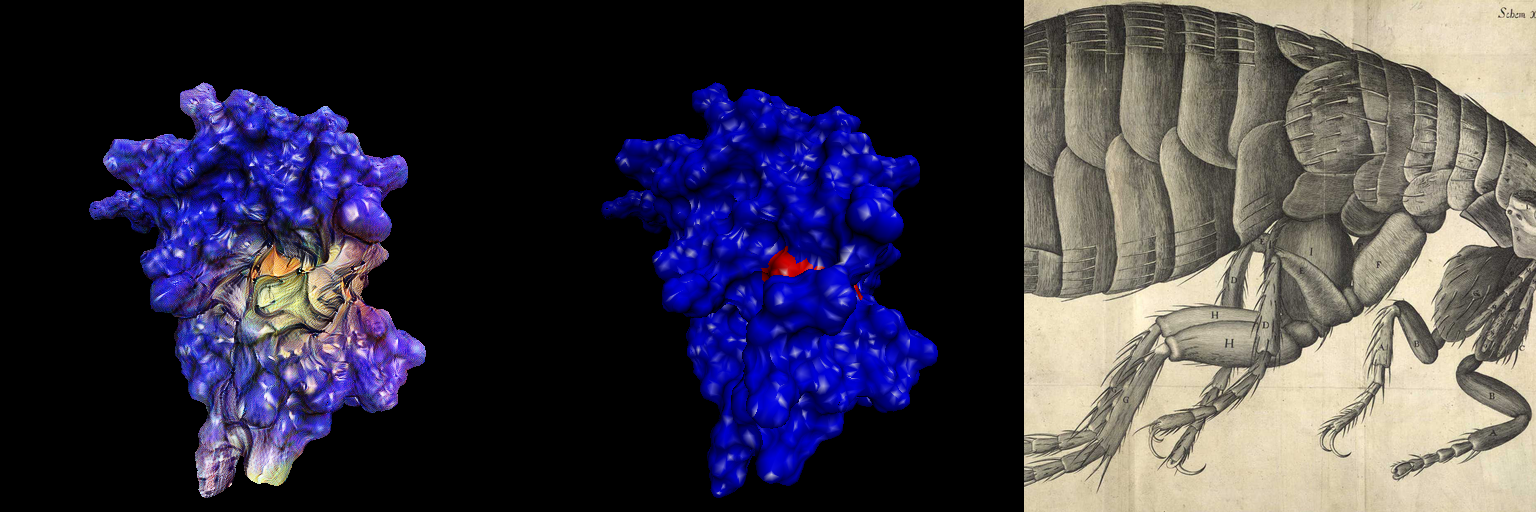

In [44]:
fname = '{0}_{1}_{2}_{3}_{4}_{5}_{6}_transform_masked.jpg'.format(content_name, style_name, model.name, 
                                            content_weight, '-'.join(content_layers), style_weight, '-'.join(style_layers))
channel_sum = np.sum(vis[-1][1], axis=-1)
mask = channel_sum >0

vis[-1][0][~mask] = np.zeros(3)
masked_vis = np.concatenate(vis[-1], axis=1)
show(masked_vis)
save(masked_vis, fname)